# 라이브러리 불러오기

In [1]:
# ! pip install -U imbalanced-learn scikit-learn
# !pip install gensim
# ! pip install optuna

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
import matplotlib.pyplot as plt

from gensim.models import FastText
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import TreebankWordTokenizer # 표준 토큰화
from nltk.corpus import stopwords # 불용어 제거
from nltk.stem import WordNetLemmatizer # 기본 형태로 변환
from imblearn.over_sampling import SMOTE # 비대칭이라 사용

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras.initializers import Constant
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기

In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/sample_submission.csv')

In [4]:
display(train_df.head())
display(test_df.head())

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa..."
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a..."


In [5]:
train_df.groupby('first_party_winner').size()

first_party_winner
0     829
1    1649
dtype: int64

# 데이터 전처리

## 단어 처리

In [6]:
# 문자 처리
cat_cols = ['first_party', 'second_party', 'facts']

# \b : 단어 경계, W* : 길이가 0이상이고 단어가 아닌 문자, w{1} : 길이가 1인 단어
short_word = re.compile(r'\W*\b\w{1}\b') # 길이가 1인 단어 찾기
tokenizer = TreebankWordTokenizer() # 단어 단위로 토큰화
stopword = stopwords.words('english') # 불용어 리스트 가져오기
lemmatizer = WordNetLemmatizer() # 단어의 기본 형태 가져오기

In [7]:
def prepro1(df):
        df = df.strip() # 공백 제거
        df = df.lower() # 소문자로 변경
        df = df.replace(',', '')
        df = df.replace('.', '')
        

        content = short_word.sub('', df) # 한 글자 단어 제거
        com = re.compile(r"[^\uAC00-\uD7A30-9a-zA-Z\s]") # 한글, 영어, 숫자 및 공백 문자를 제외한 모든 문자를 매칭
        content = com.sub('', content)
        tokens = tokenizer.tokenize(content) # 단어 토큰화
        token_lst = []

        for token in tokens:
            if token not in stopword: #불용어 제거
                token_lst.append(lemmatizer.lemmatize(token, 'n')) # 단어의 기본 형태 가져오기
        return token_lst

In [8]:
train_df['first_party'] = train_df['first_party'].apply(prepro1)
train_df['second_party'] = train_df['second_party'].apply(prepro1)
train_df['facts'] = train_df['facts'].apply(prepro1)

test_df['first_party'] = test_df['first_party'].apply(prepro1)
test_df['second_party'] = test_df['second_party'].apply(prepro1)
test_df['facts'] = test_df['facts'].apply(prepro1)

In [9]:
all_text = train_df['first_party'].tolist() + train_df['second_party'].tolist() + train_df['facts'].tolist()

In [10]:
train_word_counts = train_df['facts'].apply(lambda x : len(str(x).split()))

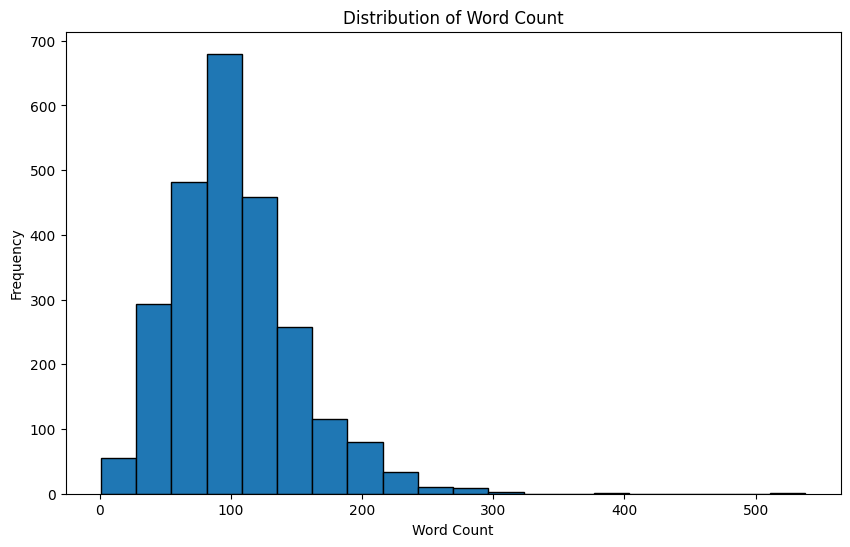

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(train_word_counts, bins=20, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count')
plt.show()

## fasttext

'FastText'를 사용해 사전 훈련된 단어 임베딩을 가져오고, 이를 사용해 keras의 임베딩 레이어를 초기화한다

=> FastText 모델에서 얻은 단어 임베딩을 임베딩 행렬로 저장하고 있습니다. 이러한 저장된 임베딩 행렬은 후에 모델을 구축할 때 사용

In [12]:
model = FastText(all_text, vector_size = 100, window = 5, min_count = 1, workers = 4, sg = 1)

# tokenizer를 사용해 단어 인덱스를 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)
word_index = tokenizer.word_index

In [13]:
embedding_dim = 100

In [14]:
# embedding matrix

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim)) # 단어 수 X 임베딩 차원

for word, i in word_index.items():
    if word in model.wv:
        embedding_vec = model.wv[word]
        embedding_matrix[i] = embedding_vec

In [15]:
# embeddings_initializer : 임베딩 레이어의 가중치를 초기화
# trainable = Fasle : 사전 훈련된 임베딩을 고정
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, embeddings_initializer = Constant(embedding_matrix), trainable = False)

In [16]:
def get_vec(model, texts):
    vects = []
    
    for text in texts:
        text_vects = []
        for word in text:
            if word in model.wv.key_to_index:
                text_vects.append(model.wv.get_vector(word))
        if len(text_vects) > 0:
            text_vects = np.mean(text_vects, axis = 0)
            vects.append(text_vects)
        else:
            vects.append(np.zeros(model.vector_size))
    
    return np.array(vects)

In [17]:
X_train_first = get_vec(model, train_df['first_party'])
X_train_second = get_vec(model, train_df['second_party'])
X_train_facts = get_vec(model, train_df['facts'])

X_train = np.concatenate([X_train_first, X_train_second, X_train_facts], axis = 1)
y_train = train_df['first_party_winner']

In [18]:
X_test_first = get_vec(model, test_df['first_party'])
X_test_second = get_vec(model, test_df['second_party'])
X_test_facts = get_vec(model, test_df['facts'])

X_test = np.concatenate([X_test_first, X_test_second, X_test_facts], axis = 1)

## 불균형 데이터 처리

In [19]:
X_smote, y_smote = SMOTE(k_neighbors=5).fit_resample(X_train, y_train)
print('train shape : {}, {}'.format(X_smote.shape, y_smote.shape))

train shape : (3298, 300), (3298,)


In [20]:
y_smote.value_counts()

first_party_winner
1    1649
0    1649
Name: count, dtype: int64

## train데이터 셋으로 train, val 데이터 셋으로 분리

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, random_state = 123, test_size = 0.2)

print('Train shape : {}, {}'.format(X_train.shape, y_train.shape))
print(y_train.value_counts())

print()

print('Validation shape : {}, {}'.format(X_val.shape, y_val.shape))
print(y_val.value_counts())

Train shape : (2638, 300), (2638,)
first_party_winner
1    1328
0    1310
Name: count, dtype: int64

Validation shape : (660, 300), (660,)
first_party_winner
0    339
1    321
Name: count, dtype: int64


In [22]:
# 차원 변경

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

In [23]:
X_train

array([[ 0.15461463,  0.50219664, -0.05179121, ..., -0.10044539,
         0.21156137, -0.12030811],
       [ 0.16206184,  0.27329791,  0.04709373, ..., -0.17021237,
         0.1606504 , -0.14930479],
       [ 0.22221737,  0.29524997, -0.06287609, ..., -0.18781312,
         0.2027446 , -0.12025161],
       ...,
       [ 0.07523935,  0.36453649, -0.10817528, ..., -0.13457872,
         0.17272072, -0.15830959],
       [ 0.09720055,  0.26590884,  0.00346637, ..., -0.19288647,
         0.28080854,  0.0270282 ],
       [ 0.17792638,  0.41726467, -0.01526904, ..., -0.1426084 ,
         0.23860209, -0.0562922 ]])

# 모델링

In [24]:
# Optuna를 사용하여 하이퍼파라미터 튜닝을 수행하기 위한 것

def objective(trial):
    C = trial.suggest_loguniform('C', 0.001, 100)
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    
    logistic_model = LogisticRegression(C = C, solver = solver, max_iter = max_iter, class_weight = class_weight)
    logistic_model.fit(X_train, y_train)
    accuracy = logistic_model.score(X_val, y_val)
    
    return accuracy

In [25]:
# objective 함수는 Optuna의 suggest_ 메서드를 사용하여 하이퍼파라미터 공간에서 샘플링하는 함수
study = optuna.create_study(direction = 'maximize')
# study 객체를 생성한 후 optimize 메서드를 사용하여 주어진 목적 함수(objective)를 최대화하는 방향으로 하이퍼파라미터를 조정
study.optimize(objective, n_trials = 50)

# Print the best hyperparameters and objective value
best_params = study.best_params
best_value = study.best_value
print("Best Parameters : ", best_params)
print("Best Value : ", best_value)

[I 2024-03-18 14:20:15,201] A new study created in memory with name: no-name-16cd79d1-2830-49a6-b3f1-e06f748a1e79
[I 2024-03-18 14:20:15,237] Trial 0 finished with value: 0.6075757575757575 and parameters: {'C': 6.137584537394515, 'solver': 'lbfgs', 'max_iter': 290, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6075757575757575.
[I 2024-03-18 14:20:15,354] Trial 1 finished with value: 0.5984848484848485 and parameters: {'C': 34.77073931483529, 'solver': 'lbfgs', 'max_iter': 500, 'class_weight': None}. Best is trial 0 with value: 0.6075757575757575.
[I 2024-03-18 14:20:17,068] Trial 2 finished with value: 0.5787878787878787 and parameters: {'C': 0.44022159368646274, 'solver': 'saga', 'max_iter': 586, 'class_weight': None}. Best is trial 0 with value: 0.6075757575757575.
[I 2024-03-18 14:20:17,088] Trial 3 finished with value: 0.5651515151515152 and parameters: {'C': 0.0890645651594613, 'solver': 'lbfgs', 'max_iter': 748, 'class_weight': None}. Best is trial 0 with value: 0.

[I 2024-03-18 14:20:37,239] Trial 36 finished with value: 0.5954545454545455 and parameters: {'C': 13.987321364896872, 'solver': 'lbfgs', 'max_iter': 204, 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6106060606060606.
[I 2024-03-18 14:20:38,971] Trial 37 finished with value: 0.5757575757575758 and parameters: {'C': 0.38613700670340173, 'solver': 'saga', 'max_iter': 494, 'class_weight': None}. Best is trial 12 with value: 0.6106060606060606.
[I 2024-03-18 14:20:38,995] Trial 38 finished with value: 0.5545454545454546 and parameters: {'C': 0.029415210858586113, 'solver': 'lbfgs', 'max_iter': 570, 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6106060606060606.
[I 2024-03-18 14:20:39,041] Trial 39 finished with value: 0.593939393939394 and parameters: {'C': 1.941287503070607, 'solver': 'newton-cg', 'max_iter': 118, 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6106060606060606.
[I 2024-03-18 14:20:39,133] Trial 40 finished with value: 0.5969696969

Best Parameters :  {'C': 6.772434114109104, 'solver': 'lbfgs', 'max_iter': 994, 'class_weight': 'balanced'}
Best Value :  0.6106060606060606


In [26]:
model = LogisticRegression(C = best_params['C'], solver = best_params['solver'], max_iter = best_params['max_iter'], class_weight = best_params['class_weight'], penalty='l2')
model.fit(X_train, y_train)
pred = model.predict(X_test)

accuracy = model.score(X_val, y_val)
print("Accuracy:", accuracy)


fpr, tpr, thresholds = roc_curve(y_val, model.predict(X_val).ravel())
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
print('Best Thresholds : {}'.format(thresholds[ix]))

Accuracy: 0.6106060606060606
Best Thresholds : 1.0


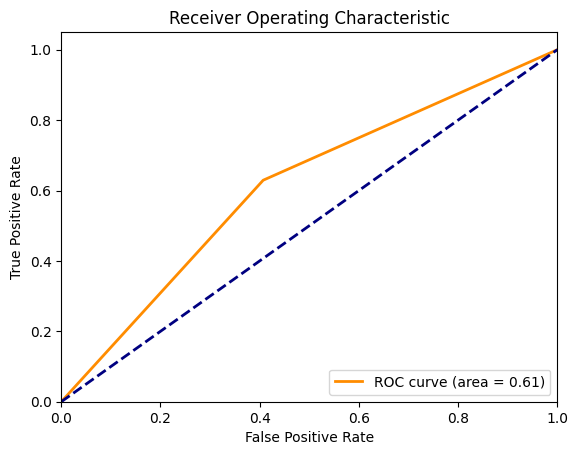

In [27]:
fpr, tpr, _ = roc_curve(y_val, model.predict(X_val).ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color = 'darkorange',
         lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


In [28]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

In [29]:
# y_train_pred = (y_train_pred > 0.5).astype(int)
# y_val_pred = (y_val_pred > 0.5).astype(int)

In [30]:
print('train accuracy : ', accuracy_score(y_train, y_train_pred))
print('validation accuracy : ', accuracy_score(y_val, y_val_pred))

train accuracy :  0.6391205458680819
validation accuracy :  0.6106060606060606


# 제출

In [31]:
# y_pred = (pred > thresholds[ix]).astype(int).flatten()
# submission_df['first_party_winner'] = y_pred
# submission_df.to_csv('fasttext_smote_logit.csv', index = False)